In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
class PositionEmbeddingLayer(nn.Module):
    def __init__(self, sequence_length, vocab_size, output_dim):
        super(PositionEmbeddingLayer, self).__init__()
        self.word_embedding_layer = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=output_dim
        )
        self.position_embedding_layer = nn.Embedding(
            num_embeddings=sequence_length, embedding_dim=output_dim
        )

    def forward(self, inputs):
        position_indices = torch.arange(inputs.size(-1))
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [3]:
class PositionEmbeddingFixedWeights(nn.Module):
  def __init__(self, vocab_size, output_dim, sequence_length, d_model):
    super().__init__()
    self.sequence_length = sequence_length
    self.d_model = d_model

    # Create the position embedding matrix
    self.position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)

    # Define the word embedding layer
    self.word_embedding_layer = nn.Embedding(vocab_size, output_dim)

  def get_position_encoding(self, seq_len, d_model):
        even_i = torch.arange(0, d_model, 2).float()
        denominator = torch.pow(10000, even_i / d_model)
        position = torch.arange(seq_len).reshape(seq_len, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

  def forward(self, inputs):
        position_indices = torch.arange(self.sequence_length)
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_matrix[position_indices]
        return embedded_words + embedded_indices

In [4]:
# Example usage
vocab_size = 10000
output_dim = 128
sequence_length = 100
d_model = 128
batch_size = 16

# Create an instance of PositionalEncoding
positional_encoding = PositionEmbeddingFixedWeights(vocab_size, output_dim, sequence_length, d_model)

# Generate a random input tensor
inputs = torch.randint(0, vocab_size, (batch_size, sequence_length))

# Apply positional encoding
encoded_inputs = positional_encoding(inputs)

print(encoded_inputs.shape)

torch.Size([16, 100, 128])


In [5]:
class TextVectorizer(nn.Module):
    def __init__(self, vocab_size, output_seq_len):
        super(TextVectorizer, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, output_seq_len, sparse=True)
        self.vocab_size = vocab_size

    def forward(self, text):
        return self.embedding(text)

technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

# Split the phrases into words and create a vocabulary
all_words = (technical_phrase + " " + wise_phrase).split()
word_to_index = {word: index for index, word in enumerate(set(all_words))}
index_to_word = {index: word for word, index in word_to_index.items()}

# Convert phrases to sequences of word indices
technical_seq = [word_to_index[word] for word in technical_phrase.split()]
wise_seq = [word_to_index[word] for word in wise_phrase.split()]

# Pad sequences to a fixed length
sequence_length = 20
technical_seq = torch.tensor(technical_seq[:sequence_length])
wise_seq = torch.tensor(wise_seq[:sequence_length])

# Pad sequences to the same length
padded_technical_seq = nn.functional.pad(technical_seq, (0, sequence_length - len(technical_seq)))
padded_wise_seq = nn.functional.pad(wise_seq, (0, sequence_length - len(wise_seq)))

# Create a batch of sequences
phrase_tensors = torch.stack([padded_technical_seq, padded_wise_seq])

# Create the TextVectorizer
total_vocab_size = len(word_to_index)
vectorization_layer = TextVectorizer(total_vocab_size, sequence_length)

# Get vectorized phrases
vectorized_phrases = vectorization_layer(phrase_tensors)
vectorized_phrases = vectorized_phrases.long()
print(vectorized_phrases)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [6]:
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
d_model = 128

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length,
                                                        total_vocabulary,
                                                        final_output_len)

fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(
    total_vocabulary, final_output_len, sequence_length, d_model)

random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

In [7]:
fixed_embedding

tensor([[[-0.0824,  1.2530,  1.2812,  ..., -0.2672,  1.9083,  0.0642],
         [ 0.7590,  0.7933,  1.9191,  ..., -0.2672,  1.9084,  0.0642],
         [ 0.8268, -0.1632,  2.2637,  ..., -0.2672,  1.9086,  0.0642],
         ...,
         [-1.0438, -0.0222,  0.5602,  ..., -0.2672,  1.9107,  0.0642],
         [-0.8334,  0.9133,  1.1680,  ..., -0.2672,  1.9109,  0.0642],
         [ 0.0674,  1.2417,  1.8279,  ..., -0.2672,  1.9110,  0.0642]],

        [[-0.0824,  1.2530,  1.2812,  ..., -0.2672,  1.9083,  0.0642],
         [ 0.7590,  0.7933,  1.9191,  ..., -0.2672,  1.9084,  0.0642],
         [ 0.8268, -0.1632,  2.2637,  ..., -0.2672,  1.9086,  0.0642],
         ...,
         [-1.0438, -0.0222,  0.5602,  ..., -0.2672,  1.9107,  0.0642],
         [-0.8334,  0.9133,  1.1680,  ..., -0.2672,  1.9109,  0.0642],
         [ 0.0674,  1.2417,  1.8279,  ..., -0.2672,  1.9110,  0.0642]]],
       grad_fn=<AddBackward0>)

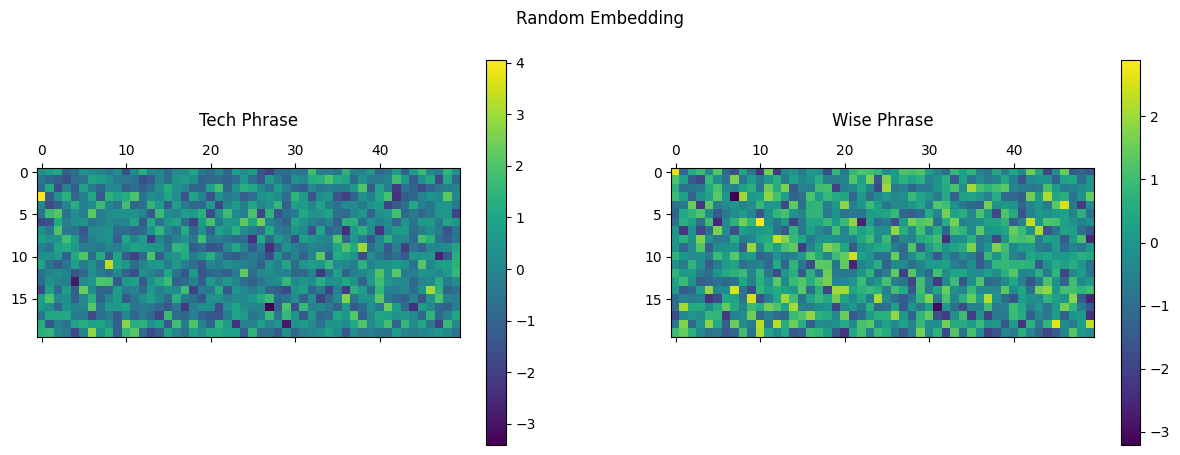

In [8]:
import matplotlib.pyplot as plt

random_embedding = torch.randn(2, sequence_length, final_output_len)

fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = random_embedding[i, :, :].reshape(sequence_length, final_output_len).numpy()
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

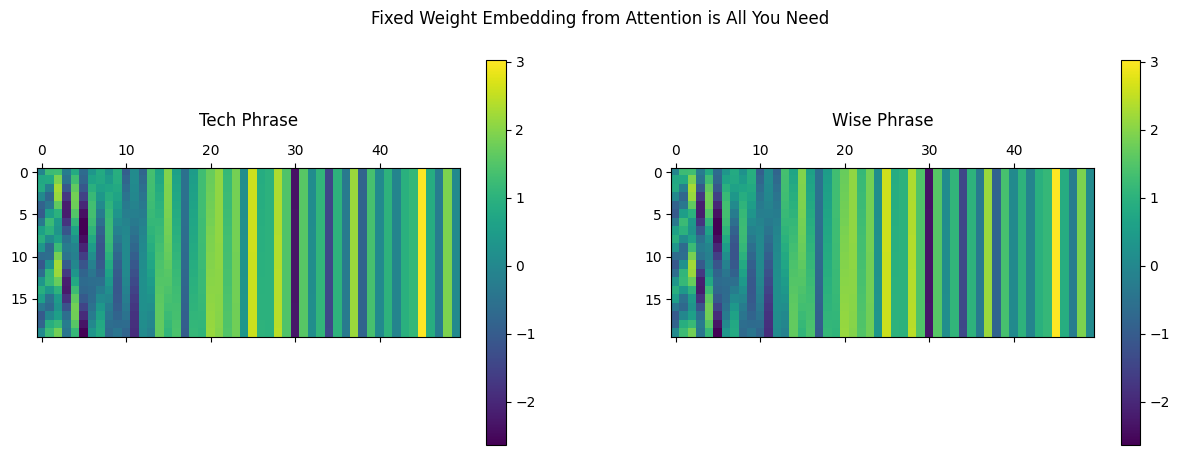

In [9]:
import torch
import matplotlib.pyplot as plt

# Assuming fixed_embedding is a PyTorch tensor with shape (2, sequence_length, final_output_len)

fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]

for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = fixed_embedding[i, :, :]
    cax = ax.matshow(matrix.detach().numpy())  # Convert tensor to numpy array for visualization
    plt.colorbar(cax)
    plt.title(title[i], y=1.2)

fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()